# Clustering analysis of 1.3 million brain cells

This tutorial demonstrates how to analyze a super large scale data using the transfer model of LANTSA.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import lantsa

## Read the data

Firstly, we use [scanpy.read_10x_h5()](https://scanpy.readthedocs.io/en/latest/generated/scanpy.read_10x_h5.html) to read 10x Chromium Megacell *1.3 Million Brain Cells from E18 Mice* dataset, which is publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.3.0/1M_neurons).

In [2]:
adata = sc.read_10x_h5('./data/1M_neurons_filtered_gene_bc_matrices_h5.h5')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1306127 × 27998
    var: 'gene_ids'

## Preprocessing

Then, we perform basic preprocessing including finding highly variable genes and log transformation.

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
sc.pp.log1p(adata)

## Landmark-based transferable subspace analysis

For super large scale dataset, we firstly devide the dataset into learning set and prediction set. Then, we perform landmark-based subspace analysis on learning set, which results in subspace representation for clustering and discriminant matrix for label transfer. Lastly, the inferred clusters of learning set are transferred to prediction set via discriminant matrix.

Here, we select 5000 samples as learning set using [sklearn.cluster.MiniBatchKeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

In [4]:
lantsa.select_learning_samples(adata, n_learning=5000, method='MiniBatchKMeans')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


We create a new object `adata_learning` storing the learning samples for subspace analysis.

In [5]:
adata_learning = adata[adata.obs['is_learning'], :]
adata_learning

View of AnnData object with n_obs × n_vars = 4992 × 27998
    obs: 'is_learning'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'select_training_samples'

Now, we perform subspace analysis to learn representation for clustering and discriminant matrix for label transfer.

In [6]:
lantsa.subspace_analysis(adata_learning, n_neighbors=100)

 23%|██████▊                       | 114/500 [00:16<00:55,  6.97it/s, relChg: 3.447e-05, recErr: 9.564e-06, converged!]
Trying to set attribute `.uns` of view, copying.


The resulting `adata_learning` is compatible with [scanpy.tl.leiden()](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html) for clustering. 

In [7]:
sc.tl.leiden(adata_learning, resolution=1, neighbors_key='subspace_analysis')

This is how the `adata_learning` looks like now.

In [8]:
adata_learning

AnnData object with n_obs × n_vars = 4992 × 27998
    obs: 'is_learning', 'leiden'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'select_training_samples', 'subspace_analysis', 'leiden'
    varm: 'discriminant'
    obsp: 'representation'

This is the inferred clusters of learning set.

In [9]:
adata_learning.obs['leiden']

AACTCAGTCCTGCCAT-1       0
AACTCCCAGGTGCACA-1       0
ACGAGCCAGCTAGTTC-1       0
ACGGAGATCCGTCAAA-1       3
AGAATAGCAGTTAACC-1       2
                        ..
TCAGGTACAGTAGAGC-133    10
TCCACACCAGTCAGAG-133     0
TCCCGATGTGATAAAC-133     0
TCTTCGGTCATCGCTC-133     1
TGTATTCTCGAGAGCA-133     1
Name: leiden, Length: 4992, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

Now, the `adata_learning` is ready for label transfer.

We transfer the clusters of learning set to the prediction set using [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [10]:
lantsa.transfer_labels(adata, adata_learning, groups='leiden')

This is how the `adata` looks like after label transfer.

In [11]:
adata

AnnData object with n_obs × n_vars = 1306127 × 27998
    obs: 'is_learning', 'leiden'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'select_training_samples', 'transfer_labels'

This is the transferred clusters of all samples.

In [12]:
adata.obs['leiden']

AAACCTGAGATAGGAG-1      1
AAACCTGAGCGGCTTC-1      1
AAACCTGAGGAATCGC-1      2
AAACCTGAGGACACCA-1      6
AAACCTGAGGCCCGTT-1      5
                       ..
TTTGTCAGTCCGACGT-133    1
TTTGTCAGTGAAAGAG-133    1
TTTGTCAGTGCGATAG-133    1
TTTGTCAGTTAAAGTG-133    2
TTTGTCATCTGAAAGA-133    2
Name: leiden, Length: 1306127, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

## Cluster marker genes

The transferred clusters are compatible with [scanpy.tl.rank_genes_groups()](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html) for detecting differentially expressed (DE) genes.

In [13]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')

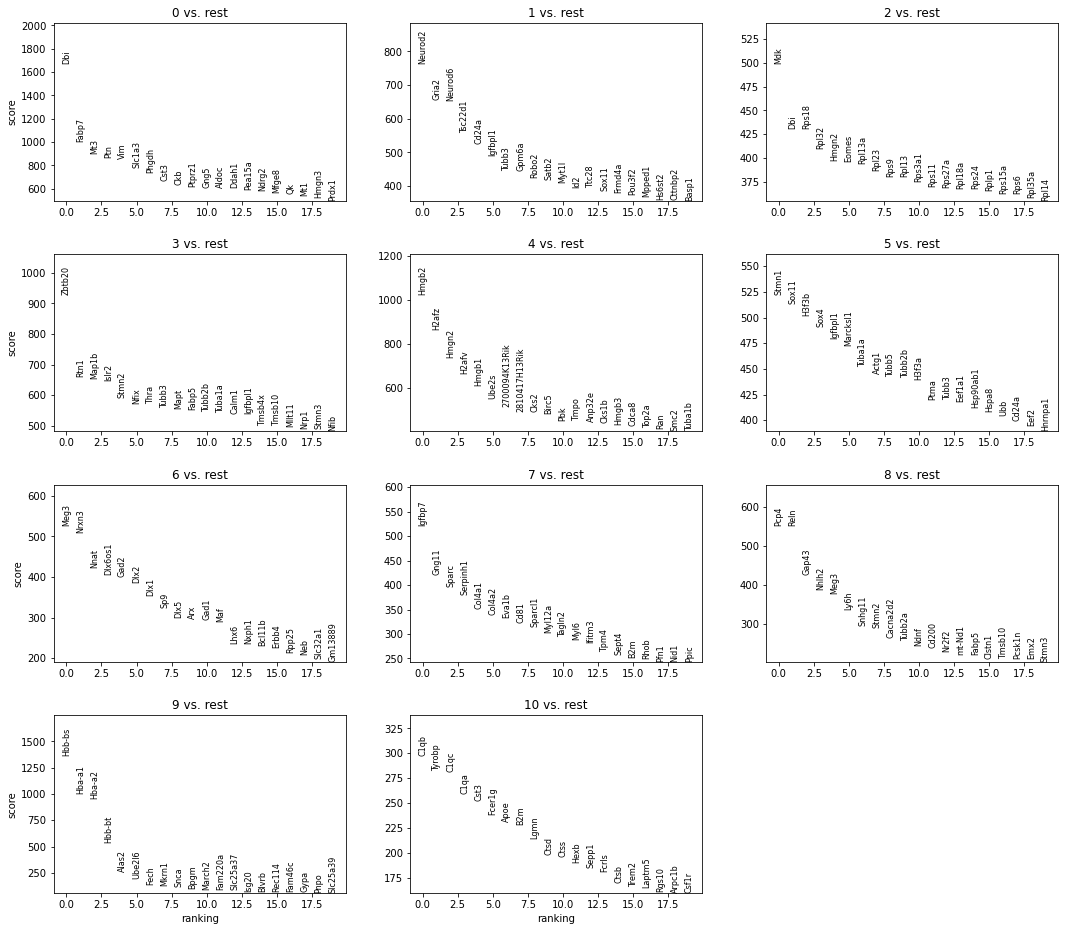

In [14]:
sc.pl.rank_genes_groups(adata, n_genes=20, ncols=3, sharey=False)

In [15]:
marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:10,:]
marker_genes

,0,1,2,3,4,5,6,7,8,9,10
0,Dbi,Neurod2,Mdk,Zbtb20,Hmgb2,Stmn1,Meg3,Igfbp7,Pcp4,Hbb-bs,C1qb
1,Fabp7,Gria2,Dbi,Rtn1,H2afz,Sox11,Nrxn3,Gng11,Reln,Hba-a1,Tyrobp
2,Mt3,Neurod6,Rps18,Map1b,Hmgn2,H3f3b,Nnat,Sparc,Gap43,Hba-a2,C1qc
3,Ptn,Tsc22d1,Rpl32,Islr2,H2afv,Sox4,Dlx6os1,Serpinh1,Nhlh2,Hbb-bt,C1qa
4,Vim,Cd24a,Hmgn2,Stmn2,Hmgb1,Igfbpl1,Gad2,Col4a1,Meg3,Alas2,Cst3
5,Slc1a3,Igfbpl1,Eomes,Nfix,Ube2s,Marcksl1,Dlx2,Col4a2,Ly6h,Ube2l6,Fcer1g
6,Phgdh,Tubb3,Rpl13a,Thra,2700094K13Rik,Tuba1a,Dlx1,Eva1b,Snhg11,Fech,Apoe
7,Cst3,Gpm6a,Rpl23,Tubb3,2810417H13Rik,Actg1,Sp9,Cd81,Stmn2,Mkrn1,B2m
8,Ckb,Robo2,Rps9,Mapt,Cks2,Tubb5,Dlx5,Sparcl1,Cacna2d2,Snca,Lgmn
9,Ptprz1,Satb2,Rpl13,Fabp5,Birc5,Tubb2b,Arx,Myl12a,Tubb2a,Bpgm,Ctsd
